In [1]:
from datasets import load_dataset
import anndata as ad
import pandas as pd
import pubchempy as pcp
import scanpy as sc
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
!{sys.executable} -m pip install pytorch-lightning
!{sys.executable} -m ipykernel install --user --name=conda-base


/bin/bash: line 1: {sys.executable}: command not found
/bin/bash: line 1: {sys.executable}: command not found


In [3]:
import sys
print(sys.path)
print(sys.executable)

['/home/ubuntu/tahoe-mars/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/ubuntu/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/ubuntu/.ipython', '/tmp/tmpp9pwey2v']
/usr/bin/python3


In [4]:
import pytorch_lightning as L
sys.path.append('..')
from modules import Model, MarsDataset, GeneSetAdaptor, SaveBestSeparateCheckpoints
from utils import _init_weights


## Load Data:

In [5]:
# making sure loss is reproducible 
train_dataset = MarsDataset("../data/train.h5")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)

# making sure loss is reproducible 1
val_dataset = MarsDataset("../data/validation.h5")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)


In [6]:
test_dataset = MarsDataset("../data/test.h5")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)


# Load Model:

In [7]:
ADAPTOR_DICT = {
    'gene_set': GeneSetAdaptor(256, 7467),
}

adaptor = ADAPTOR_DICT["gene_set"]
adaptor.apply(_init_weights)


# Load Model
model = Model(
    cell_embedding_dim=1280,
    smiles_embedding_dim=784,
    dosage_embedding=64,
    backbone_embedding_dim=512,
    adaptor=adaptor,
    mars_training=True,
    lr=1e-4,
    weight_decay=1e-5,
    max_epochs=10,
    criterion="mse",
)


In [8]:
# load fine-tune model
checkpoint_path = '/home/ubuntu/tahoe-mars/model_checkpoints/model_train-huber_lr1e-4-epochepoch=19.ckpt' 
finetune_model =  Model.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    adaptor=adaptor,  # You may need to pass this since it might not be saved in the checkpoint
    mars_training=True,  # Add any other parameters that aren't saved in the checkpoint
    criterion="mse"
)

# Inference/Evaluate

In [9]:
# put on cuda
finetune_model = finetune_model.to('cuda')

### Train Inference:

In [10]:
# track values

train_pred_logits = [] 
train_vision_scores = []

for batch in train_dataloader:

    # get the input features
    cell_repr, smile_repr, dosage = batch[0]

    # get the ground truth vision scores
    vision_scores = batch[1]

    with torch.no_grad():
        logits = finetune_model(*(cell_repr.to('cuda'), smile_repr.to('cuda'), dosage.to('cuda')))

    train_pred_logits.append(logits.cpu())
        

In [11]:
# concatenate predictions and ground truth labels
train_pred_logits, train_vision_scores = torch.cat(train_pred_logits), torch.tensor(train_dataset[:][1])

In [12]:
# criteria
model.criterion = MeanSquaredError()
huber_loss = torch.nn.HuberLoss()

In [13]:
# get loss values
train_mse_loss = model.criterion(train_pred_logits, train_vision_scores).item()
train_huber_loss = huber_loss(train_pred_logits, train_vision_scores).item()

In [14]:
print(f'{train_mse_loss=}, {train_huber_loss=}')

train_mse_loss=0.026754230260849, train_huber_loss=0.013308067806065083


### Validation Inference:

In [15]:
# track values

val_pred_logits = [] 
val_vision_scores = []

for batch in val_dataloader:

    # get the input features
    cell_repr, smile_repr, dosage = batch[0]

    # get the ground truth vision scores
    vision_scores = batch[1]

    with torch.no_grad():
        logits = finetune_model(*(cell_repr.to('cuda'), smile_repr.to('cuda'), dosage.to('cuda')))

    val_pred_logits.append(logits.cpu())
    

In [16]:
# concatenate predictions and ground truth labels
val_pred_logits, val_vision_scores = torch.cat(val_pred_logits), torch.tensor(val_dataset[:][1])

In [17]:
# get loss values
val_mse_loss = model.criterion(val_pred_logits, val_vision_scores).item()
val_huber_loss = huber_loss(val_pred_logits, val_vision_scores).item()

In [18]:
print(f'{val_mse_loss=}, {val_huber_loss=}')

val_mse_loss=0.026937345042824745, val_huber_loss=0.013401099480688572


### Testing Inference:

In [19]:
# track values

test_pred_logits = [] 
test_vision_scores = []

for batch in test_dataloader:

    # get the input features
    cell_repr, smile_repr, dosage = batch[0]

    # get the ground truth vision scores
    vision_scores = batch[1]

    with torch.no_grad():
        logits = finetune_model(*(cell_repr.to('cuda'), smile_repr.to('cuda'), dosage.to('cuda')))

    test_pred_logits.append(logits.cpu())
    

In [20]:
# concatenate predictions and ground truth labels
test_pred_logits, test_vision_scores = torch.cat(test_pred_logits), torch.tensor(test_dataset[:][1])

In [21]:
# get loss values
test_mse_loss = model.criterion(test_pred_logits, test_vision_scores).item()
test_huber_loss = huber_loss(test_pred_logits, test_vision_scores).item()

In [22]:
print(f'{test_mse_loss=}, {test_huber_loss=}')

test_mse_loss=0.026945481076836586, test_huber_loss=0.013405424542725086


In [23]:
train_mse_baseline, val_mse_baseline, test_mse_baseline = torch.var(train_vision_scores), torch.var(val_vision_scores), torch.var(test_vision_scores)

## Visualizations:

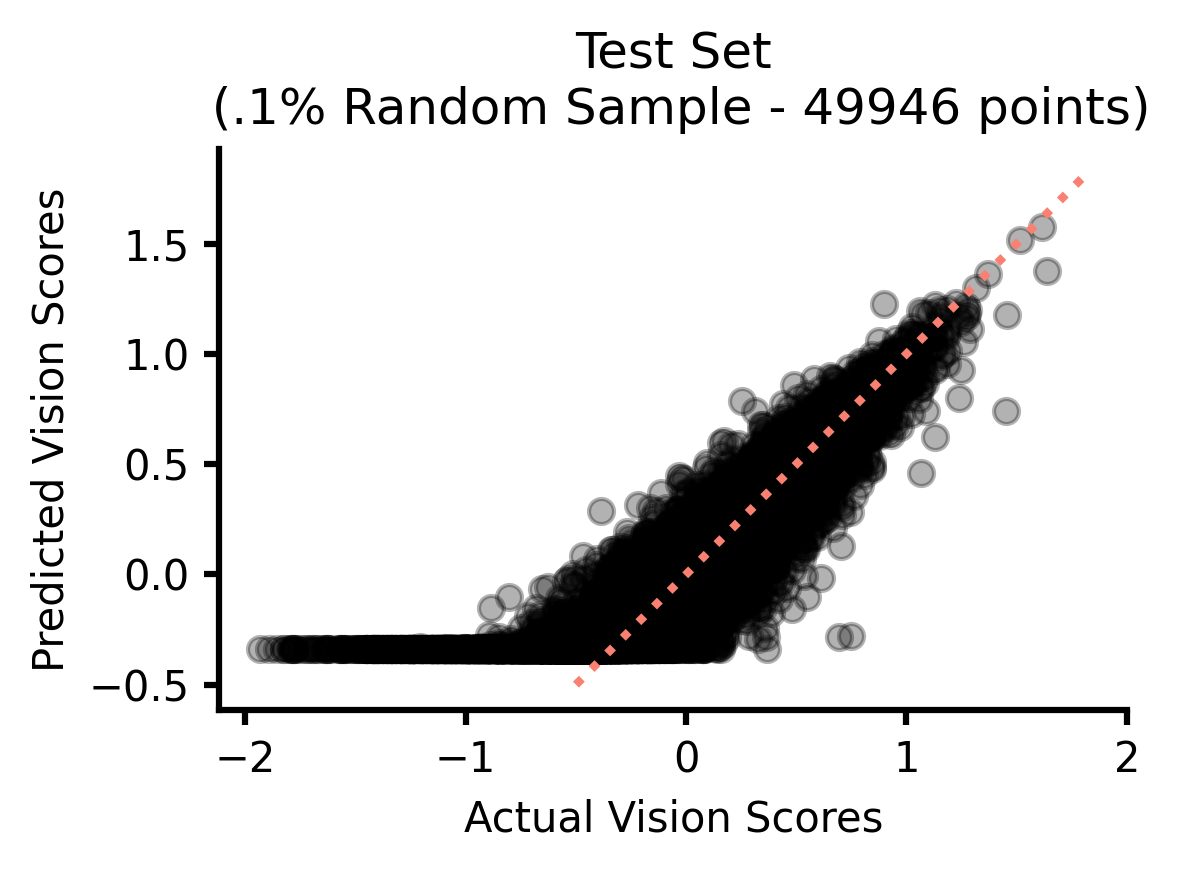

In [44]:
# Convert to numpy and flatten
test_vision_scores_flat = test_vision_scores.flatten().numpy()
test_pred_logits_flat = test_pred_logits.flatten().numpy()

# Get total number of points
total_points = len(test_vision_scores_flat)

# Calculate 1% of the data
sample_size = int(total_points * 0.001)
sample_size = max(1, sample_size)  # Ensure at least 1 point

# Generate random indices for 1% sample
random_indices = np.random.choice(total_points, size=sample_size, replace=False)

# Sample the data
sampled_scores = test_vision_scores_flat[random_indices]
sampled_predictions = test_pred_logits_flat[random_indices]

# Plot the sample
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
plt.scatter(sampled_scores, sampled_predictions, alpha=0.3, color='k')

# Get range for perfect agreement line
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
range_min = -0.5
range_max = max(x_max, y_max)

# Perfect agreement line (y=x)
plt.plot([range_min, range_max], [range_min, range_max], color='salmon', linestyle=':', linewidth=2)

plt.title(f'Test Set\n (.1% Random Sample - {sample_size} points)')
plt.xlabel('Actual Vision Scores')
plt.ylabel('Predicted Vision Scores')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase thickness of remaining spines
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Make ticks thicker too
ax.tick_params(width=1.5)

plt.tight_layout()
plt.show()

In [46]:
train_mse_loss

0.026754230260849

In [49]:
r2_vision_scores = [
    1-train_mse_loss/train_mse_baseline.item(),
    1-val_mse_loss/val_mse_baseline.item(),
    1-test_mse_loss/test_mse_baseline.item()
]

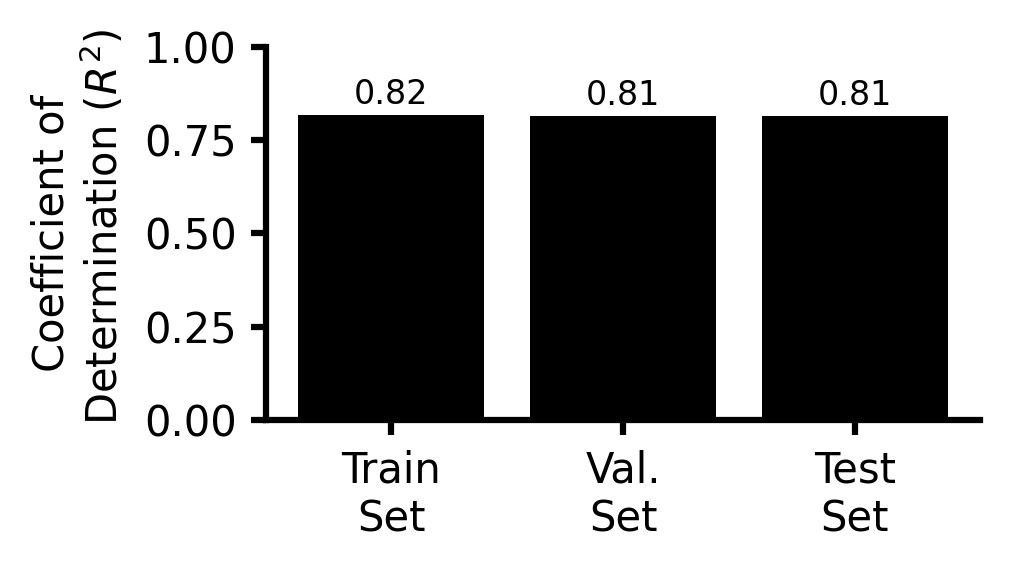

In [61]:
plt.figure(figsize=(3,2), dpi=300)
bars = plt.bar(
    ['Train\nSet', 'Val.\nSet', 'Test\nSet'],
    r2_vision_scores,
    color='k'
)
plt.ylim([0,1])

# Get axes
ax = plt.gca()

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase thickness of remaining spines
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Make ticks thicker too
ax.tick_params(width=1.5)

# Add values above bars (2 decimal places)
for bar, value in zip(bars, r2_vision_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.ylabel('Coefficient of\n Determination ($R^2$)') 
plt.show()

In [50]:
r2_vision_scores

[0.8163757840698364, 0.8147186990318348, 0.814403785144138]